# MEPSA Tests 

#### DA FARE
- [ ] Implementare il taglio su minimo 0.128 secondi tra i picchi e vedere cosa succede alla distribuzione di deltaT e di Npeaks  

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import signal
from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

%config InlineBackend.figure_format='retina' # very useful command for high-res images
%matplotlib inline

from statistical_test import *

#SEED=42
#np.random.seed(SEED)

In [2]:
# set the username for the path of the files:
user='LB'
#user='AF'
#user='bach'

if user=='bach':
    # library paths
    sys.path.append('/home/bazzanini/PYTHON/genetic/lc_pulse_avalanche/statistical_test')
    sys.path.append('/home/bazzanini/PYTHON/genetic/lc_pulse_avalanche/lc_pulse_avalanche')
    # real data
    batse_path = '/astrodata/guidorzi/CGRO_BATSE/'
    swift_path = '/astrodata/guidorzi/Swift_BAT/'
    sax_path   = '/astrodata/guidorzi/BeppoSAX_GRBM/'
    # simulations
    batse_sim_path     = '/home/bazzanini/PYTHON/genetic/lc_pulse_avalanche/simulations/batse/'
    swift_sim_path     = '/home/bazzanini/PYTHON/genetic/lc_pulse_avalanche/simulations/swift/'
    beppo_sax_sim_path = '/home/bazzanini/PYTHON/genetic/lc_pulse_avalanche/simulations/sax/'
    # mepsa
    mepsa_path           = './mepsa.so'
    ex_pattern_path      = './excess_pattern_MEPSA_v0.dat'
    batse_mepsa_res_path = '/astrodata/guidorzi/CGRO_BATSE/PEAKS_ALL/'
elif user=='LB':
    # real data
    batse_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/CGRO_BATSE/'
    swift_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/Swift_BAT/'
    sax_path   = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/BeppoSAX_GRBM/'
    # simulations
    batse_sim_path     = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/batse/'
    swift_sim_path     = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/swft/'
    beppo_sax_sim_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/sax/'
    # mepsa
    mepsa_path           = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/pyMEPSA/mepsa.so'
    ex_pattern_path      = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/pyMEPSA/excess_pattern_MEPSA_v0.dat'
    batse_mepsa_res_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/CGRO_BATSE/PEAKS_ALL/'
elif user=='AF':
    batse_path = 'E:/grb_to_test/CGRO_BATSE/'
    batse_mepsa_res_path = 'E:/grb_to_test/CGRO_BATSE/PEAKS_ALL/'
    swift_path = 'E:/grb_to_test/Swift_BAT/'
    sax_path   = 'E:/grb_to_test/BeppoSAX_GRBM/'
    batse_sim_path   = 'E:/grb_to_test/simulations/batse/'
    swift_sim_path   = 'E:/grb_to_test/simulations/swift/'
    beppo_sax_sim_path_hr = 'E:/grb_to_test/simulations/sax_hr/'
    beppo_sax_sim_path_lr = 'E:/grb_to_test/simulations/sax_lr/'
    mepsa_path = 'C:/Users/Lisa/Documents/GitHub/lc_pulse_avalanche/pyMEPSA/mepsa.so'
    ex_pattern_path = 'C:/Users/Lisa/Documents/GitHub/lc_pulse_avalanche/pyMEPSA/excess_pattern_MEPSA_v0.dat'
else:
    raise ValueError('Assign to the variable "user" a correct username!')

# LOAD DATA

In [3]:
t_i     = 0   # [s]
t_f     = 150 # [s]
t_f_sax = 50  # [s]

# BATSE
bin_time_batse     = instr_batse['res'] # temporal resolution (bins) for BATSE [s]
test_times_batse   = np.linspace(t_i, t_f, int((t_f-t_i)/bin_time_batse))
sn_threshold_batse = instr_batse['sn_threshold']
t90_threshold      = instr_batse['t90_threshold'] 
t90_frac           = 15

# Swift
bin_time_swift     = instr_swift['res'] # temporal resolution (bins) for Swift [s]
test_times_swift   = np.linspace(t_i, t_f, int((t_f-t_i)/bin_time_swift))
sn_threshold_swift = instr_swift['sn_threshold']
t90_threshold      = instr_swift['t90_threshold'] 
t90_frac           = 15

# BeppoSAX (HR)
bin_time_sax_hr   = instr_sax['res']      # temporal resolution (bins) for BeppoSAX (HIGH res) [s]
test_times_sax_hr = np.linspace(t_i, t_f_sax, int((t_f_sax-t_i)/bin_time_sax_hr))
sn_threshold_sax  = instr_sax['sn_threshold'] 
t90_threshold     = instr_sax['t90_threshold'] 
t90_frac          = 15

# BeppoSAX (LR)
bin_time_sax_lr     = instr_sax_lr['res'] # temporal resolution (bins) for BeppoSAX (LOW res) [s]
test_times_sax_lr   = np.linspace(t_i, t_f, int((t_f-t_i)/bin_time_sax_lr))
sn_threshold_sax_lr = instr_sax_lr['sn_threshold'] 
t90_threshold       = instr_sax_lr['t90_threshold'] 
t90_frac            = 15

### Load the SIMULATED batse GRBs

In [4]:
### Load the simulated BATSE GRBs

# load all data
grb_list_sim_batse = load_lc_sim(path=batse_sim_path)
# apply constraints
grb_list_sim_batse = apply_constraints(grb_list=grb_list_sim_batse, 
                                       bin_time=bin_time_batse, 
                                       t90_threshold=t90_threshold, 
                                       t90_frac=t90_frac,
                                       sn_threshold=sn_threshold_batse, 
                                       t_f=t_f)

100%|██████████| 2000/2000 [00:19<00:00, 102.60it/s]


Total number of simulated GRBs:  2000
Total number of input GRBs:  2000
GRBs with negative duration:  0
GRBs that satisfy the constraints:  2000


## Test 5: Number of significative peaks

#### Run MEPSA on the simulated curves for BATSE (SUPER SLOW!)

In [31]:
# reb_factor     = 32
# peak_sn_level  = 5
# n_of_peaks_sim = [runMEPSA(mepsa_path=mepsa_path, 
#                            ex_pattern_file_path=ex_pattern_path, 
#                            grb_file_path=grb.data_file_path, 
#                            nbins=reb_factor, 
#                            grb_name=grb.name, 
#                            sn_level=peak_sn_level) for grb in tqdm(grb_list_sim_batse)]

#### Alternatively, read the result of MEPSA from the folder in which they are stored
When we run the function `runMEPSA()` an output file for each GRB is produce; we store these files in the directory `path` used in the cell below:

In [5]:
if user=='AF':
    path='E:/grb_to_test/MEPSA results/BATSE_sim_paper_par/'
elif user=='LB':
    path='/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/statistical_test/res_mepsa/MEPSA_res/06/'

reb_factor          = 32
peak_sn_level       = 5
mepsa_out_file_list = [path+file for file in os.listdir(path)]
n_of_peaks_sim      = readMEPSAres(mepsa_out_file_list=mepsa_out_file_list, 
                                   maximum_reb_factor=reb_factor, 
                                   sn_level=peak_sn_level)

#### Read the MEPSA outputs for the real BATSE data already evaluated by Cristiano

In [6]:
reb_factor          = 32
peak_sn_level       = 5
mepsa_out_file_list = [batse_mepsa_res_path+file for file in os.listdir(batse_mepsa_res_path) if file.startswith('peaks_')]
n_of_peaks_batse    = readMEPSAres(mepsa_out_file_list=mepsa_out_file_list, 
                                   maximum_reb_factor=reb_factor, 
                                   sn_level=peak_sn_level)

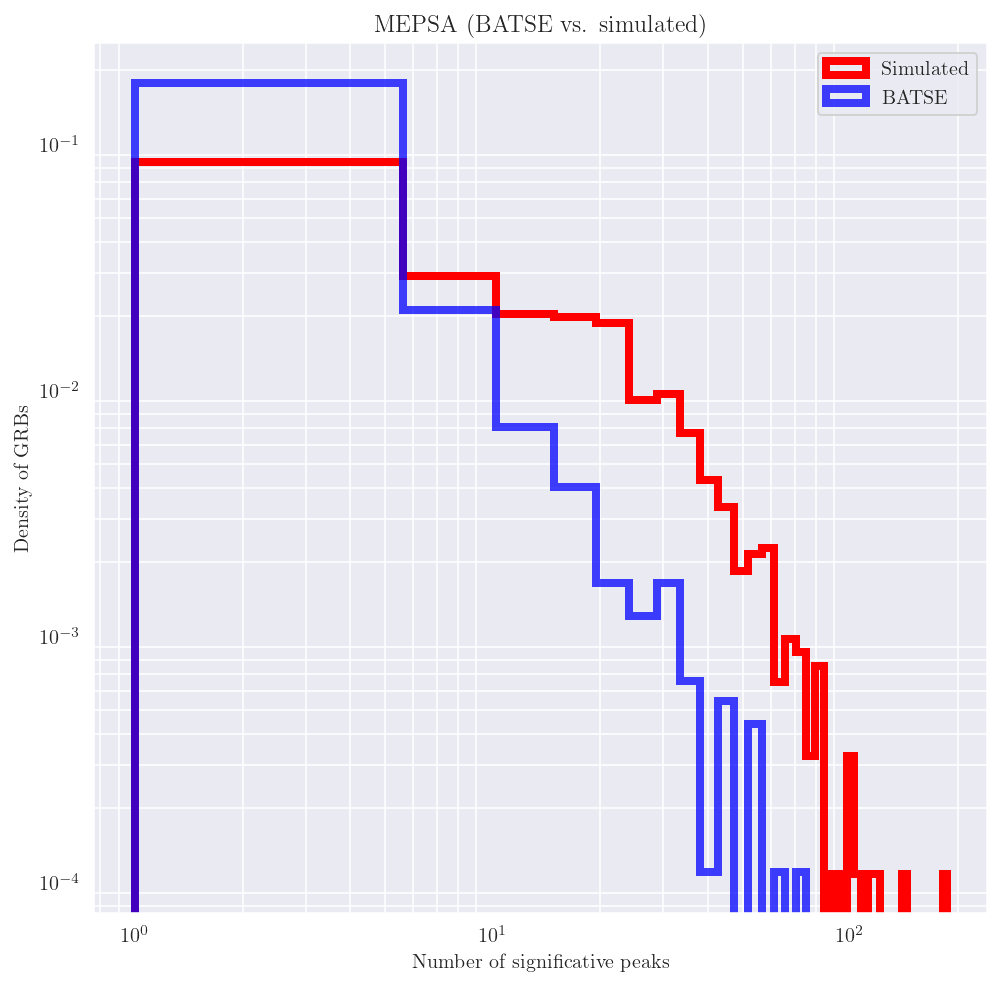

In [7]:
n_bins = 40
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
n, bins, _ = ax.hist(n_of_peaks_sim, 
         bins=n_bins, 
         label ='Simulated', 
         alpha=1.00,
         color='r',
         histtype='step',
         linewidth=4,
         density=True)
ax.hist(n_of_peaks_batse, 
         bins=bins,
         alpha=0.75,
         label='BATSE', 
         color='b',
         histtype='step',
         linewidth=4,
         density=True)
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(which='both')
ax.set_ylabel('Density of GRBs')
ax.set_xlabel('Number of significative peaks')
plt.title('MEPSA (BATSE vs. simulated)')
ax.legend()
plt.show()

## Peak count method test

In [8]:
if user=='AF':
    path='C:/Users/Lisa/Desktop/Mepsa_test3/dataset/'
elif user=='LB':
    path=batse_sim_path
grb_list_test = load_lc_sim(path=path)
# apply constraints
grb_list_test = apply_constraints(grb_list=grb_list_test, 
                                  bin_time=bin_time_batse, 
                                  t90_threshold=t90_threshold, 
                                  t90_frac=t90_frac,
                                  sn_threshold=sn_threshold_batse, 
                                  t_f=t_f)

100%|██████████| 2000/2000 [00:19<00:00, 102.40it/s]


Total number of simulated GRBs:  2000
Total number of input GRBs:  2000
GRBs with negative duration:  0
GRBs that satisfy the constraints:  2000


In [9]:
reb_factor     = 32
peak_sn_level  = 5
n_of_peaks_sim = [runMEPSA(mepsa_path=mepsa_path, 
                           ex_pattern_file_path=ex_pattern_path, 
                           grb_file_path=grb.data_file_path, 
                           nbins=reb_factor, 
                           grb_name=grb.name, 
                           sn_level=peak_sn_level) for grb in tqdm(grb_list_test)]

  0%|          | 0/2000 [00:00<?, ?it/s]

OSError: dlopen(/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/pyMEPSA/mepsa.so, 0x0006): tried: '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/pyMEPSA/mepsa.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/pyMEPSA/mepsa.so' (no such file), '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/pyMEPSA/mepsa.so' (no such file)

In [11]:
if user=='AF':
    sim_time_deltas = np.loadtxt('C:/Users/Lisa/Desktop/Mepsa_test3/time_distances.txt')
elif user=='LB':
    sim_time_deltas = np.loadtxt('/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/statistical_test/res_mepsa/additional/06/time_distances.txt')

In [12]:
sim_time_mepsa = []
if user=='AF':
    path = 'C:/Users/Lisa/Desktop/Mepsa_test3/MEPSA_res'
elif user=='LB':
    path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/statistical_test/res_mepsa/MEPSA_res/06/'
for file in os.listdir(path):
    mepsa_res = open(path + file, 'r')
    mepsa_res.readline()
    peak_times = []
    for line in mepsa_res:
        peak_times.append(float(line.split()[3]))
    peak_times = np.array(peak_times)
    sim_time_mepsa.extend(np.diff(peak_times))

In [13]:
np.min(sim_time_mepsa)

0.12799999999992906

## Results with both FWHM selection and minimum delay time selection

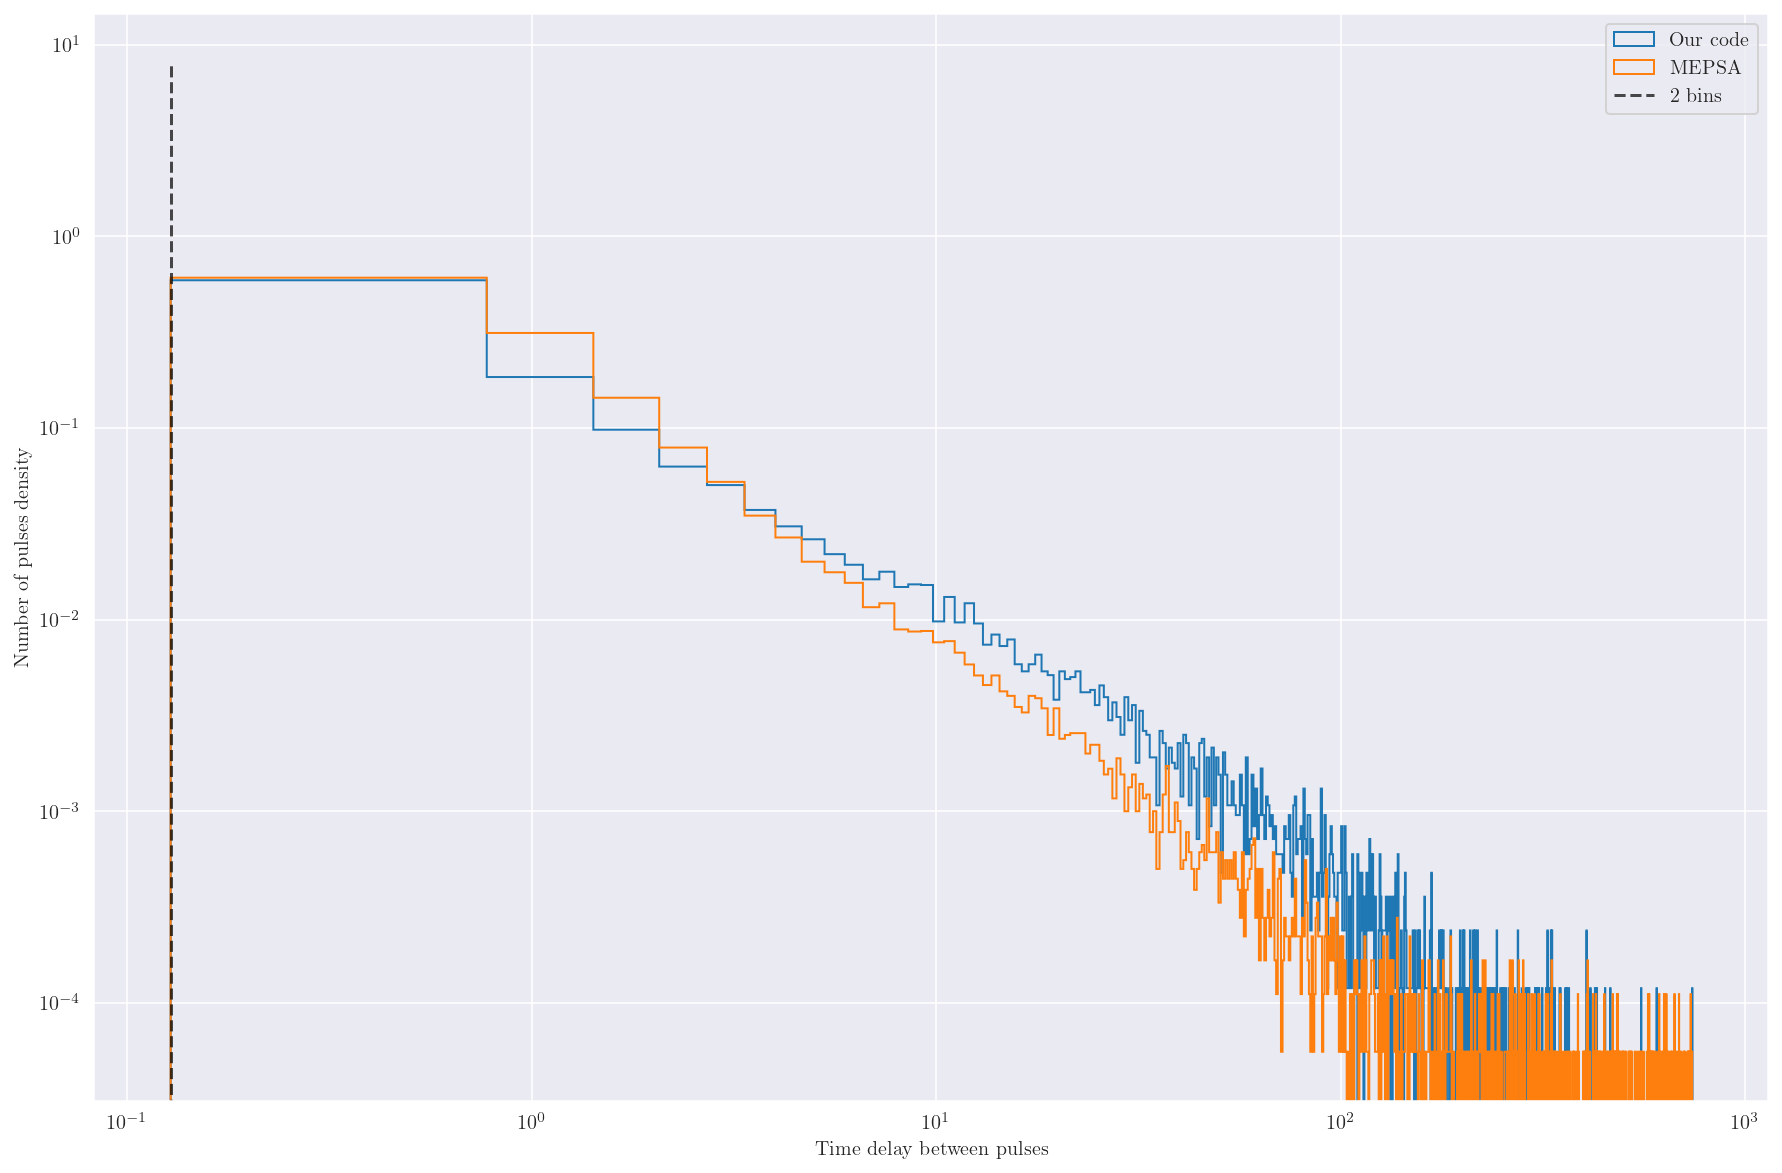

In [16]:
#print(min(sim_time_deltas))
plt.figure(figsize=(15,10))
n, bins, patches = plt.hist(sim_time_deltas, bins='auto', histtype='step', density=True, label='Our code')
_,    _,       _ = plt.hist(sim_time_mepsa,  bins=bins,   histtype='step', density=True, label='MEPSA')
plt.plot([0.128,0.128],[0,8], c='k', ls='--', alpha=0.7, label='2 bins')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Number of pulses density')
plt.xlabel('Time delay between pulses')
plt.legend()

In [21]:
from scipy.stats import anderson_ksamp, ks_2samp

def perform_KS_AD(distr_1, distr_2):
    res_ad = anderson_ksamp([distr_1,distr_2] )
    res_ks = ks_2samp(distr_1,distr_2)
    print('AD (p-value): ', res_ad.significance_level)
    print('KS (p-value): ', res_ks.pvalue)
    return [res_ad.significance_level, res_ks.pvalue] 

In [60]:
grb_name = range(2000)

if user=='AF':
    gen_file = open("C:/Users/Lisa/Desktop/MEPSA_test3/n_of_pulses.txt", 'r')
elif user=='LB':
    gen_file = open("/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/statistical_test/res_mepsa/additional/04_15/n_of_pulses.txt", 'r')
    
good_pulses = []
#generated_pulses = []
for line in gen_file:
    good_pulses.append(float(line.split()[0]))
    #generated_pulses.append(float(line.split()[2]))

mepsa_pulses = []
for grb in grb_name:
    if user=='AF':
        mepsa_pulses.append(len(open('C:/Users/Lisa/Desktop/MEPSA_test3/MEPSA_res/{0}.dat'.format(grb),'r').readlines()) -1 )
    elif user=='LB':
        mepsa_pulses.append(len(open('/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/statistical_test/res_mepsa/MEPSA_res/04/{0}.dat'.format(grb),'r').readlines()) -1 )

/var/folders/x0/m_j50m4x6_l77kk23zbp4gfm0000gn/T/ipykernel_11438/2028205289.py:4: UserWarning: p-value capped: true value larger than 0.25
  res_ad = anderson_ksamp([distr_1,distr_2] )


AD (p-value):  0.25
KS (p-value):  0.706866891160545


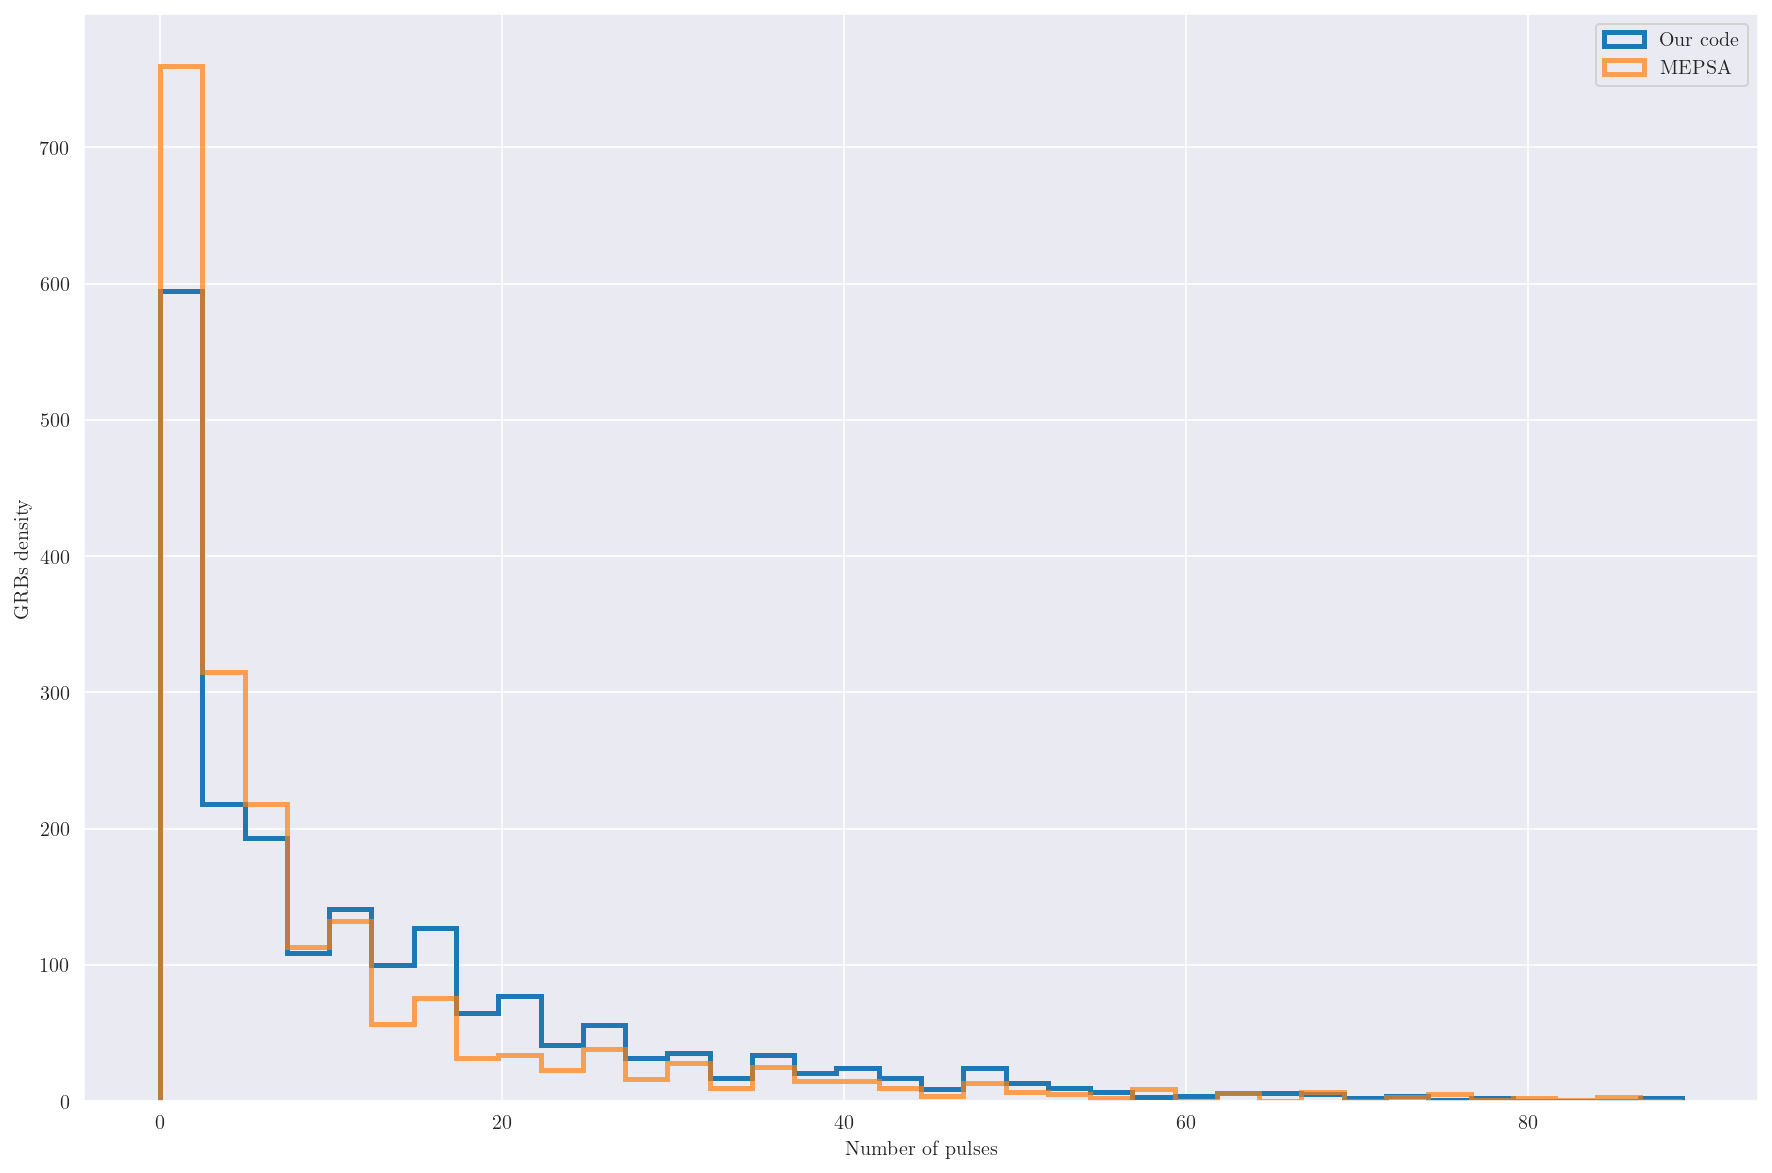

In [61]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot()
n_bins = 'auto'
n_good, bins, patches = ax.hist(good_pulses,  bins=n_bins, label='Our code', histtype='step', linewidth=2.5)
n_mepsa,   _,      _  = ax.hist(mepsa_pulses, bins=bins,   label='MEPSA',    histtype='step', linewidth=2.5, alpha=0.7)
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.grid(which='both')
ax.set_xlabel('Number of pulses')
ax.set_ylabel('GRBs density')
ax.legend()
plt.plot()

_ = perform_KS_AD(n_good, n_mepsa)

#### v6
- 5:
    - AD (p-value):  0.19764220684248163
    - KS (p-value):  0.3506382141764657
- 10:
    - AD (p-value):  0.25
    - KS (p-value):  0.9256519492948191
- 15:
    - AD (p-value):  0.25
    - KS (p-value):  0.9997180010908584
- 25:
    - AD (p-value):  0.25
    - KS (p-value):  0.6036534585381046
- 50:
    - D (p-value):  0.011180604597572657
    - KS (p-value):  0.05224838094271614

In [36]:
v6_x  = np.array([5, 10, 15, 25, 50])
v6_AD = np.array([0.19764220684248163, 0.25, 0.25, 0.25, 0.011180604597572657])
v6_KS = np.array([0.3506382141764657, 0.9256519492948191, 0.9997180010908584, 0.6036534585381046, 0.05224838094271614])

#### v4
- 5:
    - D (p-value): 
    - KS (p-value):
- 10:
    - D (p-value): 
    - KS (p-value): 
- 15:
    - AD (p-value):  0.25
    - KS (p-value):  0.706866891160545
- 50:
    - AD (p-value):  0.011473604755315028
    - KS (p-value):  0.08735018691301626

In [62]:
v4_x  = np.array([15, 50])
v4_AD = np.array([0.25, 0.011473604755315028])
v4_KS = np.array([0.706866891160545, 0.08735018691301626])

#### paper
- 5:
    - D (p-value): 
    - KS (p-value):
- 10:
    - D (p-value): 
    - KS (p-value): 
- 15:
    - D (p-value):  
    - KS (p-value):
- 50:
    - AD (p-value):  0.0019071521679397843
    - KS (p-value):  0.011511738725894704

In [63]:
vp_x  = np.array([50])
vp_AD = np.array([0.0019071521679397843])
vp_KS = np.array([0.011511738725894704])

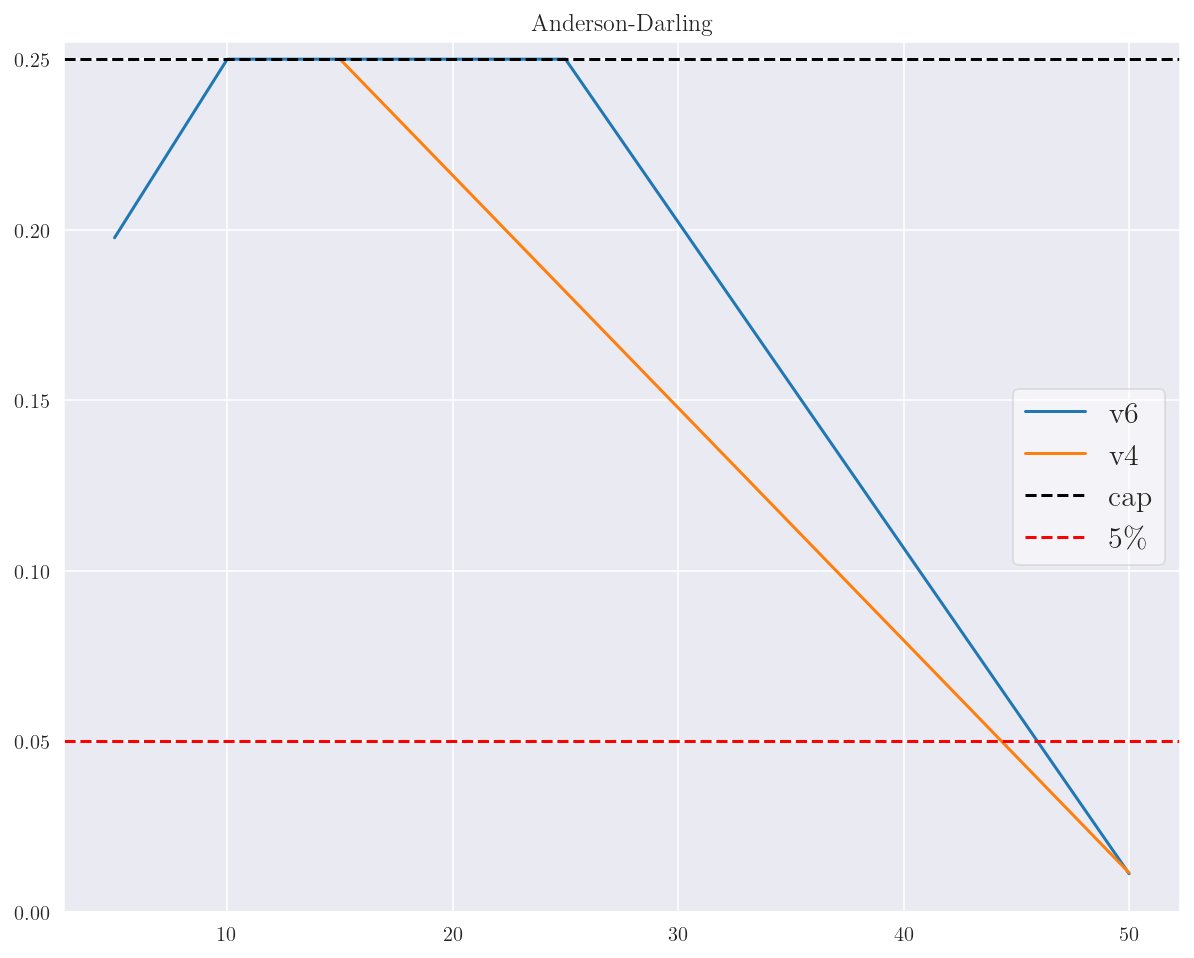

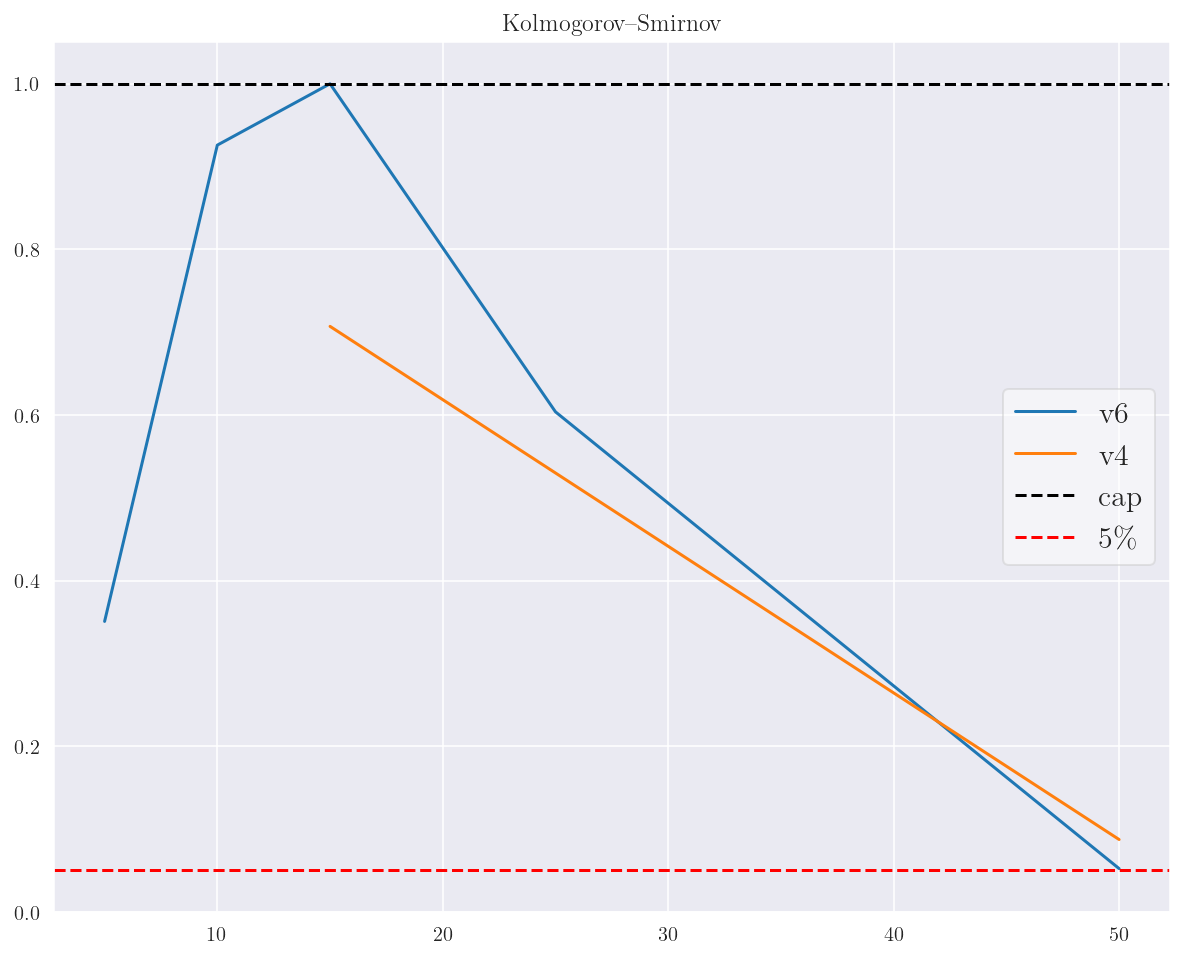

In [76]:
plt.figure(figsize=(10,8))
plt.plot(v6_x, v6_AD, label='v6')
plt.plot(v4_x, v4_AD, label='v4')
plt.axhline(0.25, 0, 50, ls='--', c='k', label='cap')
plt.axhline(0.05, 0, 50, ls='--', c='r', label='5\%')
plt.ylim(0,0.255)
plt.title('Anderson-Darling')
plt.legend(prop={'size':15}, facecolor='white', framealpha=0.5)
plt.show()

plt.figure(figsize=(10,8))
plt.plot(v6_x, v6_KS, label='v6')
plt.plot(v4_x, v4_KS, label='v4')
plt.axhline(1, 0, 50, ls='--', c='k', label='cap')
plt.axhline(0.05, 0, 50, ls='--', c='r', label='5\%')
plt.ylim(0,1.05)
plt.title('Kolmogorov–Smirnov')
plt.legend(prop={'size':15}, facecolor='white', framealpha=0.5)
plt.show()

In [30]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

mepsa_pulses = np.array(mepsa_pulses)

bwrange = np.linspace(0.01, 10.0, 100) # Test 50 bandwidths from 0.01 to 1.0
#print(bwrange)

K    = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), 
                    {'bandwidth': bwrange}, 
                    cv=K)  # Try each bandwidth with K-folds
# Fit the histogram data
grid.fit(mepsa_pulses[:, None]) 
h_opt = grid.best_params_['bandwidth']
print('optimal bandwisth: h_opt =', h_opt)

optimal bandwisth: h_opt = 5.862727272727272


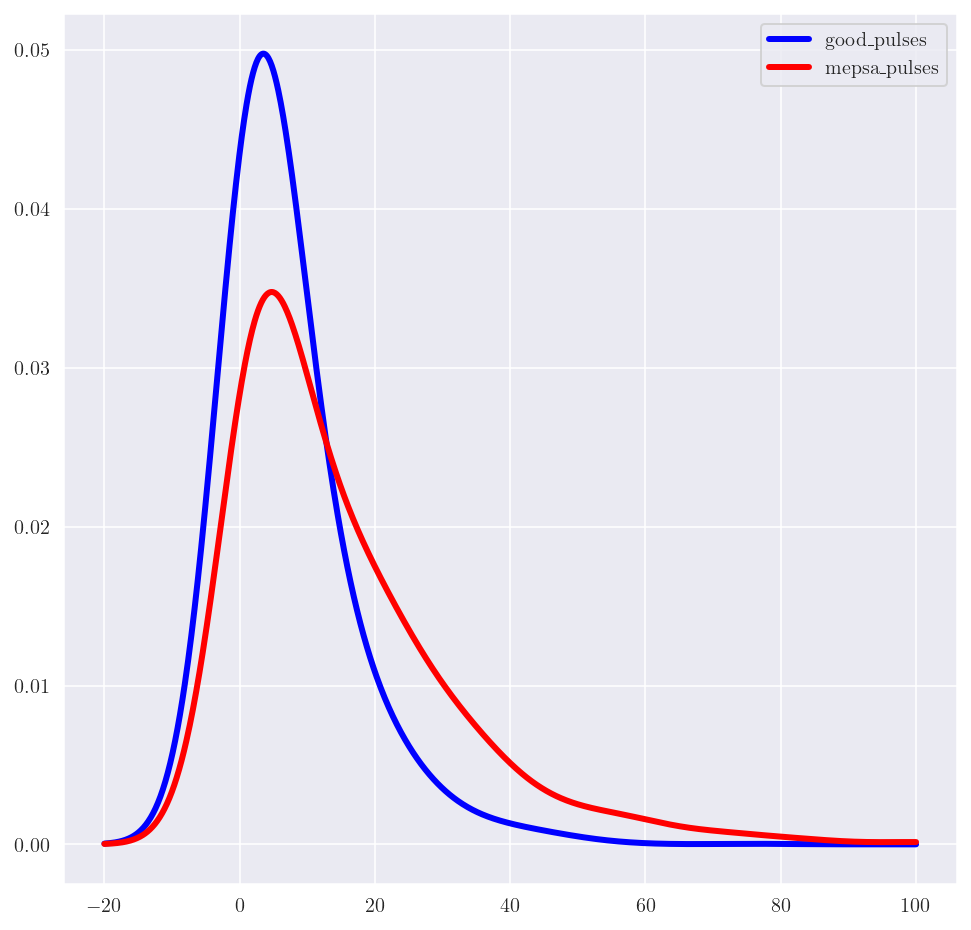

In [57]:
from scipy import stats

good_pulses  = np.array(good_pulses)
mepsa_pulses = np.array(mepsa_pulses)

h_opt         = 5.9
x_grid        = np.linspace(-20, 100, 1000)
y_plot_good   = stats.norm.pdf(x_grid, good_pulses[:, None],  h_opt)
y_plot_mepsa  = stats.norm.pdf(x_grid, mepsa_pulses[:, None], h_opt)
y_plot_good  /= (len(np.array(good_pulses)))
y_plot_mepsa /= (len(np.array(mepsa_pulses)))
kde_good      = y_plot_good.sum(0)
kde_mepsa     = y_plot_mepsa.sum(0)
# plot
fig = plt.figure(figsize=(8, 8))
ax  = fig.add_subplot(111)
ax.plot(x_grid, kde_good,  c='b', lw=3, label='good_pulses')
ax.plot(x_grid, kde_mepsa, c='r', lw=3, label='mepsa_pulses')
plt.legend()
plt.show()

In [ ]:
from scipy.optimize import curve_fit

def powerlawFunc(x, N,a):
    return N*(x)**a

x = (bins + np.roll(bins,1))/2 
x = x[1:]
y = n_mepsa

par, cov = curve_fit(powerlawFunc, x, y)
y_fit    = powerlawFunc(x, *par)
err_par  = np.sqrt(np.diag(cov))

Risultati fit: (parametri, errori)
con i dati del codice: (array([607.32600191,  -0.8249303 ]), array([34.69563094,  0.05005611]) </br>
con i dati di MEPSA: (array([517.31707726,  -0.75682532]), array([44.81378864,  0.06543106]))

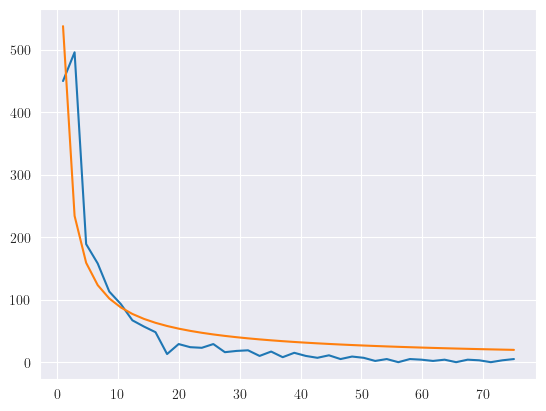

In [10]:
plt.plot(x,y)
plt.plot(x, y_fit)

#### Non fitta bene una powerlaw, ci deve essere un cambio di velocità ad un certo punto. Provo a fittare due rette spezzate sul grafico loglog

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


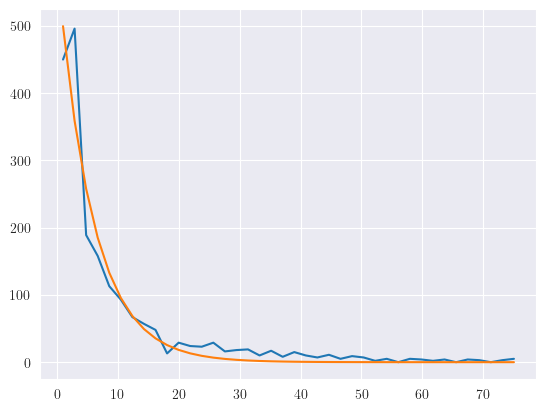

In [34]:
from scipy.optimize import curve_fit

def expFunc(x, N,a):
    return N*np.exp(-a*x)

x = (bins + np.roll(bins,1))/2 
x = x[1:]
y = n_mepsa

par, cov = curve_fit(expFunc, x, y)
y_fit = expFunc(x, *par)
err_par = np.sqrt(np.diag(cov))

plt.plot(x,y)
plt.plot(x, y_fit)

### Parametri Fit con esponenziale negativa: </br>

par = (array([5.89511931e+02, 1.74157505e-01]),</br>
err_par = array([3.36192968e+01, 1.39144840e-02]))

In [36]:
par, err_par

(array([5.89511931e+02, 1.74157505e-01]),
 array([3.36192968e+01, 1.39144840e-02]))

Text(0, 0.5, 'GRBs density')

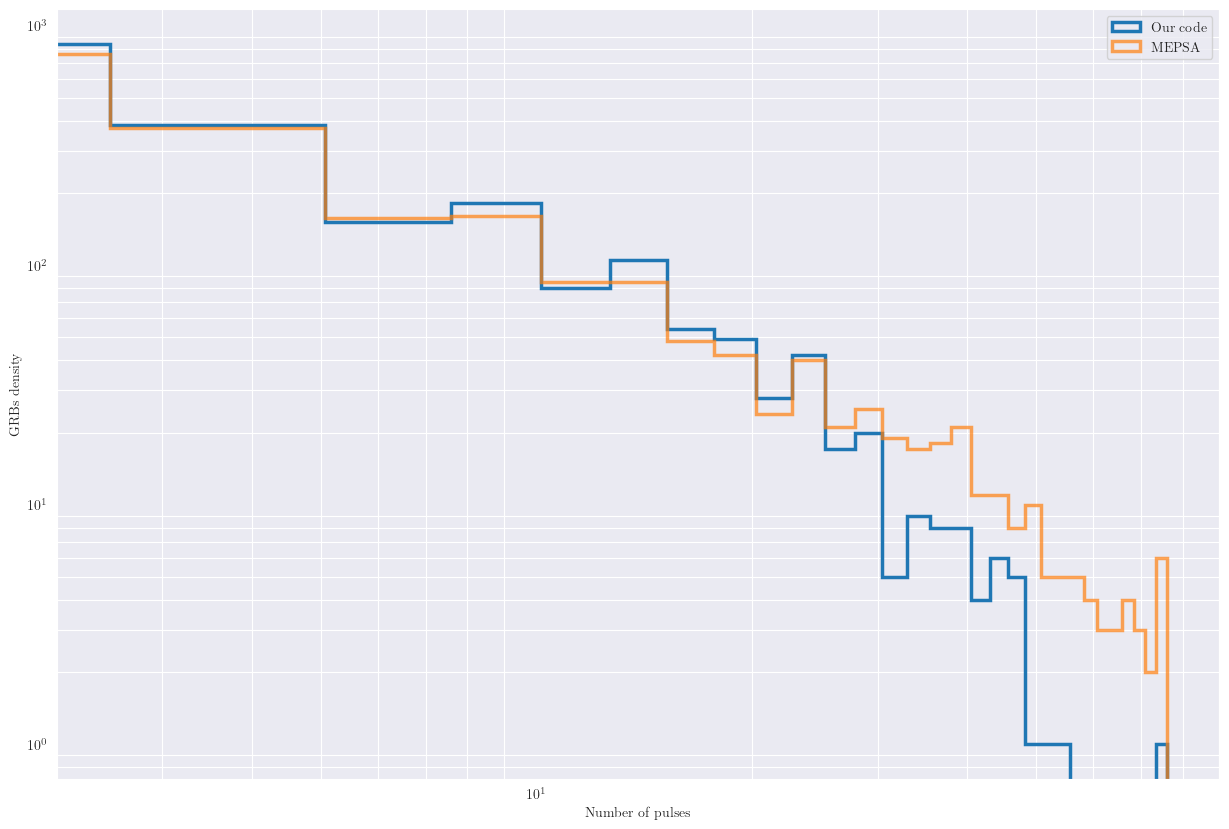

In [11]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot()
n_bins = 30
n_good, bins, patches = ax.hist(good_pulses, bins = n_bins, label = 'Our code', histtype = 'step', linewidth = 2.5)
n_mepsa, _, _, = ax.hist(mepsa_pulses, bins = bins, label = 'MEPSA', histtype = 'step', linewidth = 2.5, alpha = 0.7)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.grid(which='both')
ax.set_xlabel('Number  of pulses')
ax.set_ylabel('GRBs density')

In [21]:
from scipy.optimize import curve_fit

def _brokenLine(x, N1,m1,q1,m2,x0):
    out = 0
    if x < x0:
        out = m1*x + q1
    else:
        q2 = x0*(m1-m2) + q1
        out = m2*x + q2
    out = N1*out
    return out 

brokenLine = np.vectorize(_brokenLine)
x = (bins + np.roll(bins,1))/2 
x = np.log10(x[1:])
y = np.log10(n_mepsa)

#par, cov = curve_fit(brokenLine, x, y, p0=(10,1,1,10,1,1,10), bounds = ([0,0,0,0,0,0,0],[10**3,np.inf,10**3,10**3,np.inf,10**3,100]))
par, cov = curve_fit(brokenLine, x, y, p0=(10,1,1,0.5,1))
y_fit = brokenLine(x, *par)
err_par = np.sqrt(np.diag(cov))

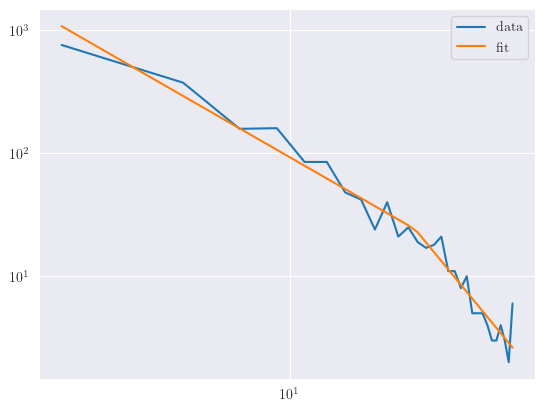

In [27]:
plt.plot(10**x,10**y, label = 'data')
plt.plot(10**x, 10**y_fit, label = 'fit')
#plt.plot(x,y, label = 'data')
#plt.plot(x, y_fit, label = 'fit')
plt.xscale('log')
plt.yscale('log')
plt.legend()

best_fit_par: (array([ 1.2456221 , -0.95494412,  2.5334082 , -2.01947782,  1.49126596]), </br>
err_on_best_fit = array([3.24483287e+06, 2.49025536e+06, 6.60649464e+06, 5.26629284e+06,
        8.46014042e-02]))

In [13]:
from scipy.stats import anderson_ksamp, ks_2samp

res_ad = anderson_ksamp([n_good,n_mepsa] )
res_ks = ks_2samp(n_good,n_mepsa )

In [14]:
print(res_ad)
print(res_ks)

Anderson_ksampResult(statistic=2.3621850860546973, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.034810223682940865)
KstestResult(statistic=0.275, pvalue=0.09707484379785862)


In [24]:
a = np.arange(0.1, 100)
b = a**(-3)
#plt.plot(a,b)
#plt.yscale('log')
#plt.xscale('log')

### Pulse detectability test

Made the plot $A_i \delta_i$ vs $|t_{i+1} - t_i| - (\delta_i + delta_{i+1})$ on as suggested by Cristiano. </br>
$t_i$: peak time  of pulse i </br>
$\delta_i$: FWHM  of pulse i </br>
$A_i$: peak rate of pulse i </br>
Test made on the GRBs simulated using the parameters of the papr, gen. 4 and (to do) gen. 6 

In [50]:
def make_pulse_det_distr(mepsa_files_pos):
    mepsa_files = os.listdir(mepsa_files_pos)
    x, y = [], []
    for file in mepsa_files:
        peak_num, _, _, peak_time, _, peak_rate, peak_fwhm, sn, _, _  = np.loadtxt(mepsa_files_pos+'/'+file, skiprows = 1, unpack=True)
        if type(peak_num) != np.float64:
            delta_t = np.diff(peak_time)
            sum_fwhm = peak_fwhm[:-1] + peak_fwhm[1:]
            y.extend((peak_rate*peak_fwhm)[:-1])
            x.extend(abs(delta_t) - sum_fwhm)
    return x, y



In [58]:
mepsa_files_pos_paper = 'E:/grb_to_test/MEPSA results/paper'
mepsa_files_pos_gen4  = 'E:/grb_to_test/MEPSA results/gen4'
#mepsa_files_pos_gen6  = 'E:/grb_to_test/MEPSA results/gen6'

x_paper, y_paper = make_pulse_det_distr(mepsa_files_pos_paper)
x_gen4, y_gen4   = make_pulse_det_distr(mepsa_files_pos_gen4)
#x_gen6, y_gen6   = make_pulse_det_distr(mepsa_files_pos_gen6)



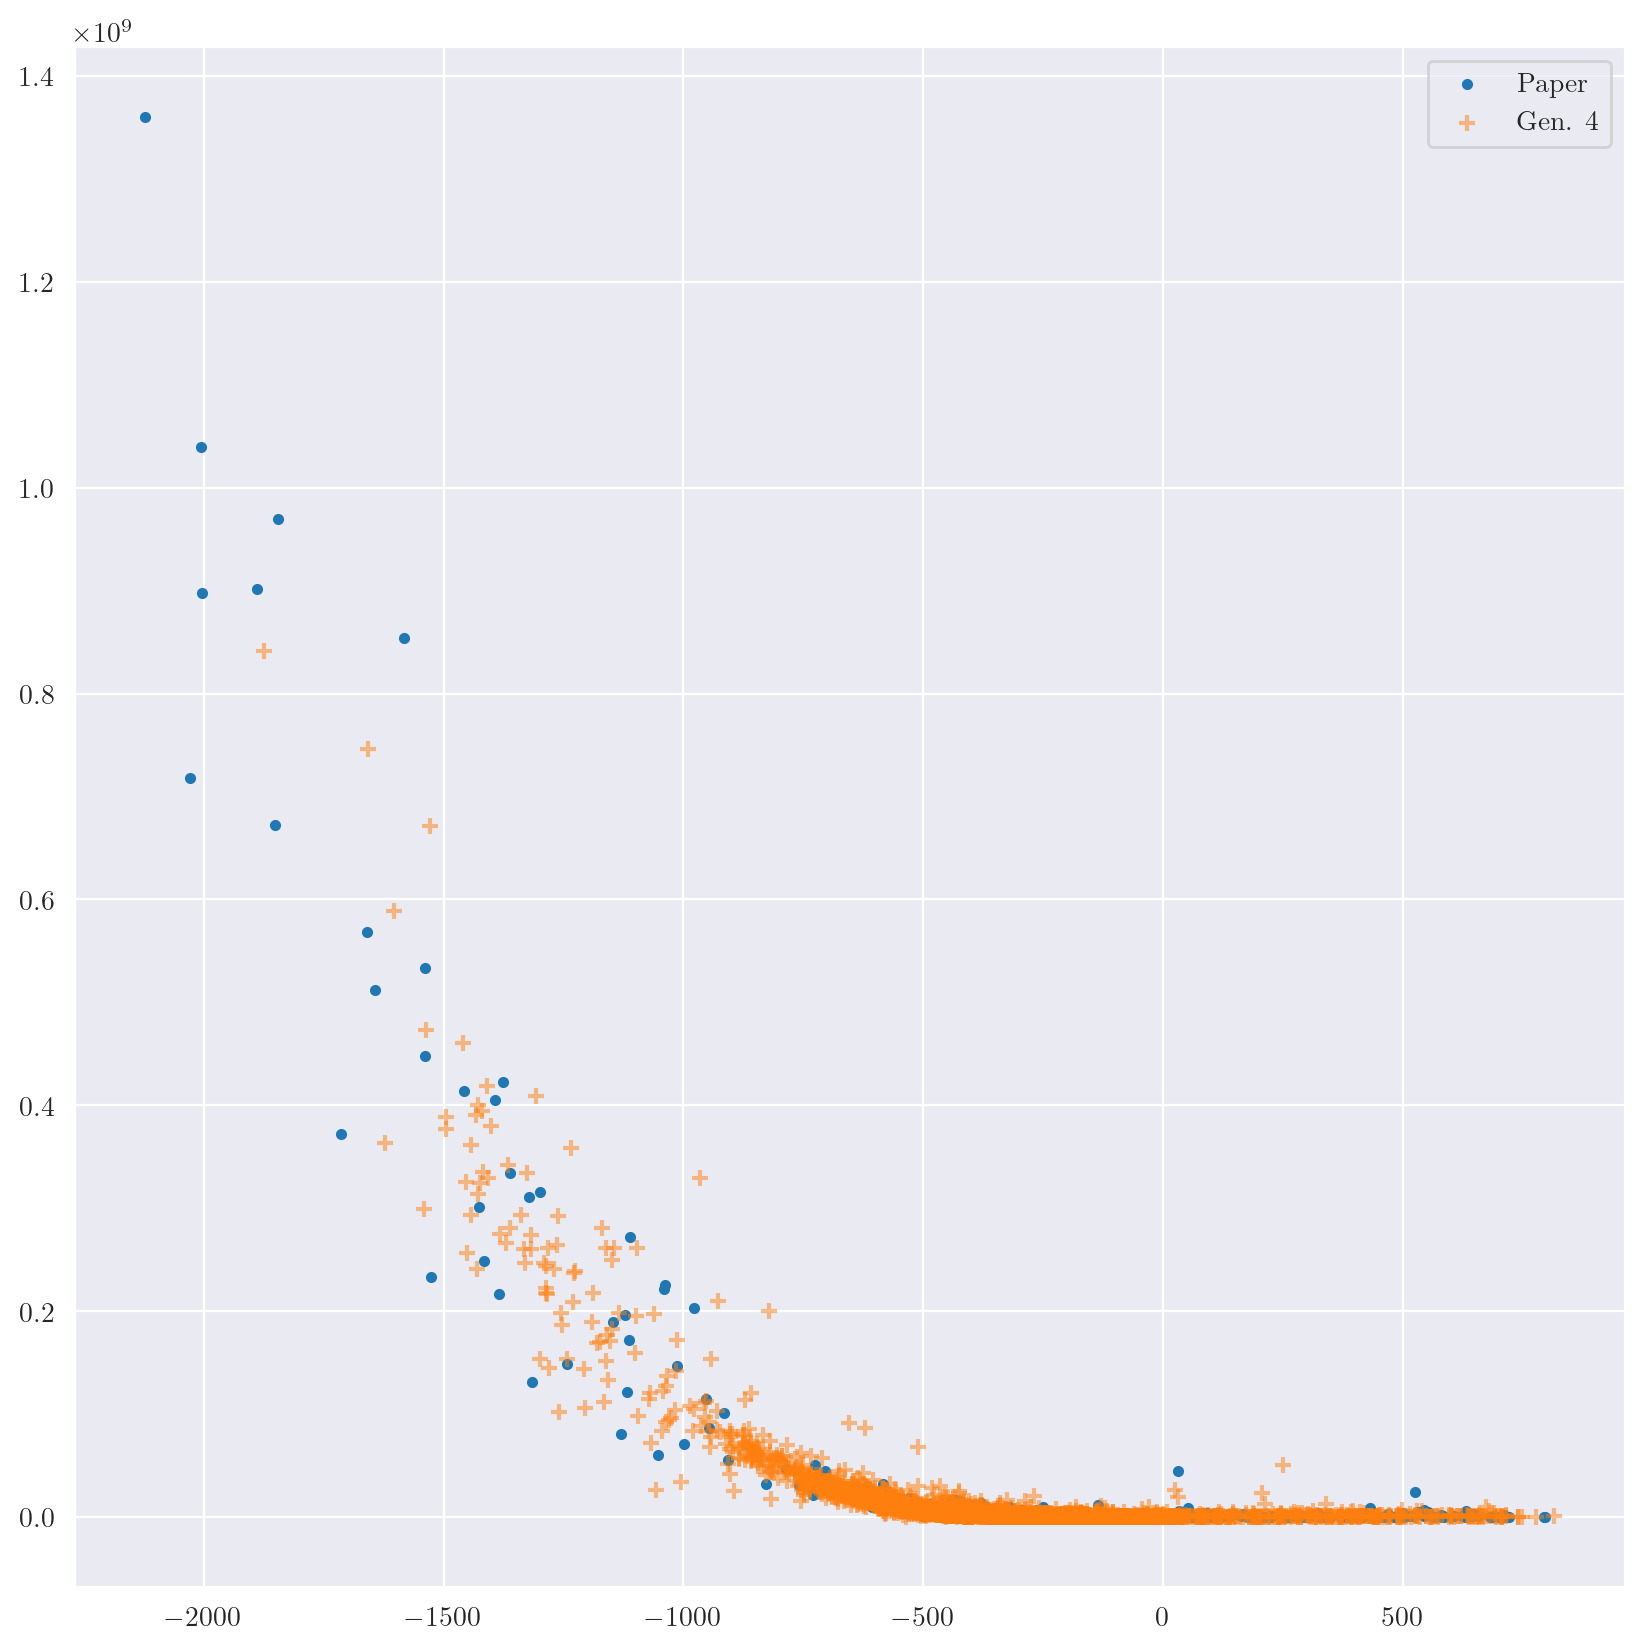

In [68]:
plt.figure(figsize=(10,10))
plt.scatter(x_paper,y_paper, marker = '.', label = 'Paper')
plt.scatter(x_gen4,y_gen4, marker = '+', label = 'Gen. 4', alpha = 0.5)
#plt.scatter(x_gen6,y_gen6, marker = 'x', label = 'Gen. 6', alpha = 0.5)
plt.legend()

#plt.xscale('log')
#plt.yscale('log')
#plt.grid(which='both')